## Importing the required libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [2]:
# In a new cell
!pip show xgboost
!pip show shap

Name: xgboost
Version: 3.1.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: C:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages
Requires: numpy, scipy
Required-by: 
Name: shap
Version: 0.50.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: 
Author: 
Author-email: Scott Lundberg <slund1@cs.washington.edu>
License: MIT License
Location: C:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages
Requires: cloudpickle, llvmlite, numba, numpy, packaging, pandas, scikit-learn, scipy, slicer, tqdm, typing-extensions
Required-by: 


In [4]:
import shap
import xgboost as xgb

In [5]:
# Display settings
pd.set_option('display.max_columns', None)
%matplotlib inline

## Load the data

In [6]:
# Load the cleaned data
filepath = r"C:\Users\My Device\Desktop\Week-3I2\dvc_data\MachineLearningRating_v3_cleaned.csv"
df = pd.read_csv(filepath)

# Basic data cleaning
df = df.drop_duplicates()

# Convert date columns if needed
if 'TransactionMonth' in df.columns:
    df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

# Filter for policies with claims
df_claims = df[df['TotalClaims'] > 0].copy()

print(f"Total policies: {len(df)}")
print(f"Policies with claims: {len(df_claims)}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

C:\Users\My Device\AppData\Local\Temp\ipykernel_21592\2305052961.py:3: DtypeWarning: Columns (18,23,24,25,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Total policies: 973382
Policies with claims: 2740

Columns in the dataset:
['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims']


## Initial Data Exploration

In [7]:
# Basic info
print("=== Data Shape ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Check data types and missing values
print("\n=== Data Types & Missing Values ===")
print(df.info())

# Basic statistics for numerical columns
print("\n=== Numerical Columns Statistics ===")
print(df.describe().T)

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

=== Data Shape ===
Rows: 973382, Columns: 52

=== Data Types & Missing Values ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973382 entries, 0 to 973381
Data columns (total 52 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   UnderwrittenCoverID       973382 non-null  int64         
 1   PolicyID                  973382 non-null  int64         
 2   TransactionMonth          973382 non-null  datetime64[ns]
 3   IsVATRegistered           973382 non-null  bool          
 4   Citizenship               973382 non-null  object        
 5   LegalType                 973382 non-null  object        
 6   Title                     973382 non-null  object        
 7   Language                  973382 non-null  object        
 8   Bank                      870597 non-null  object        
 9   AccountType               973382 non-null  object        
 10  MaritalStatus             965123 non-null  obj

## Visualize key distributions

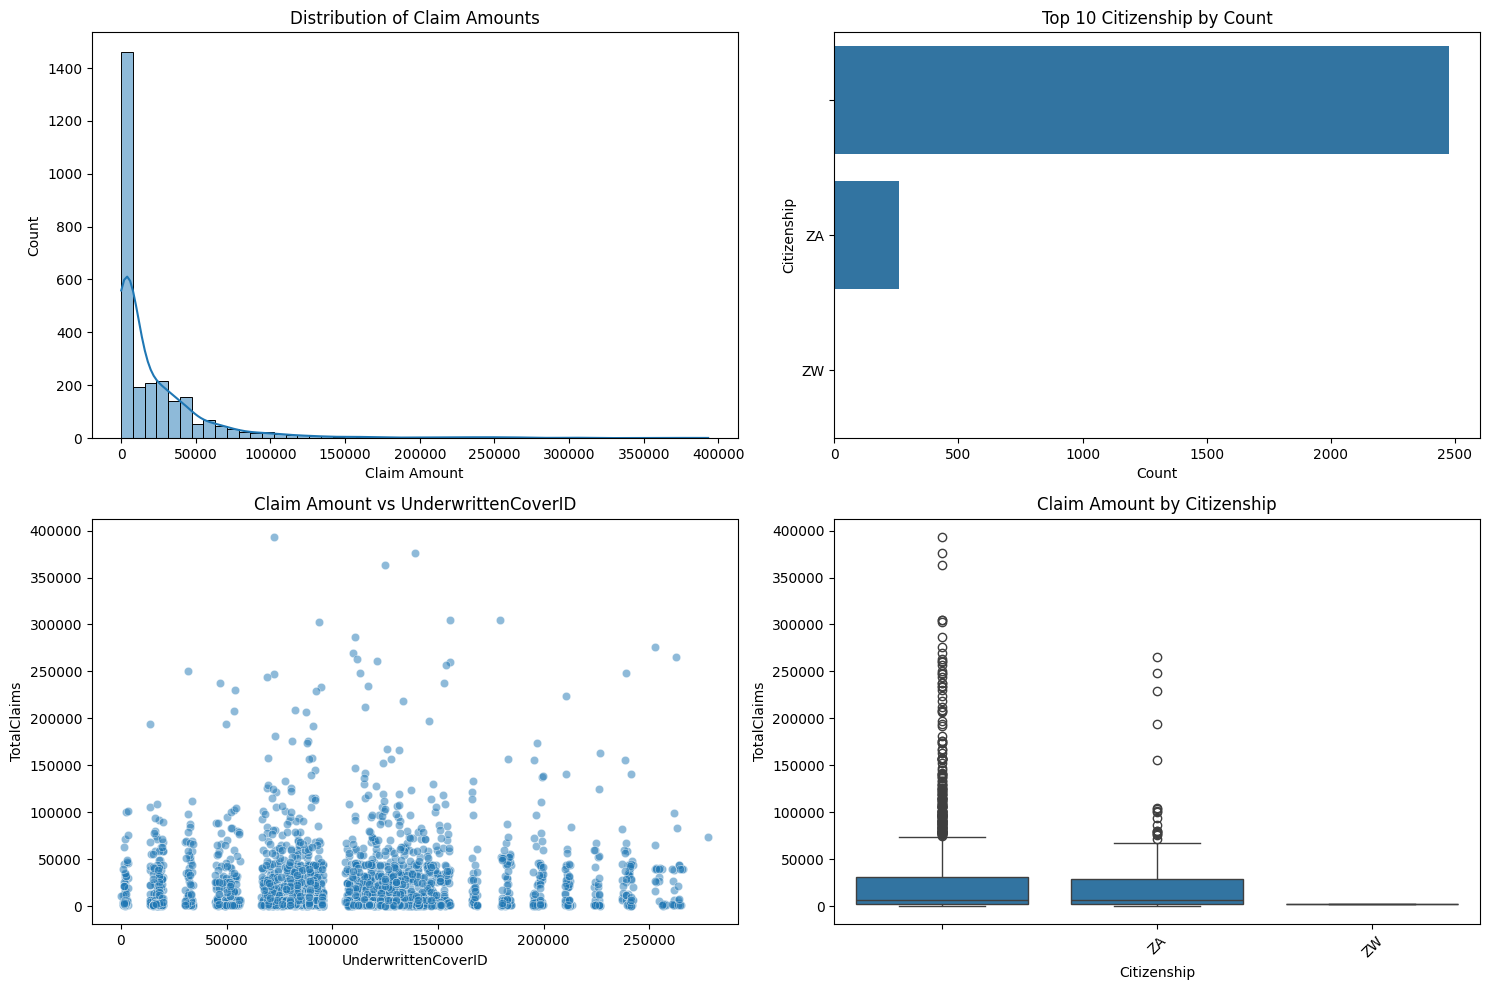

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of TotalClaims
plt.subplot(2, 2, 1)
sns.histplot(df_claims['TotalClaims'], bins=50, kde=True)
plt.title('Distribution of Claim Amounts')
plt.xlabel('Claim Amount')

# Plot 2: Top 10 values for the first categorical column we can find
categorical_cols = df_claims.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    cat_col = categorical_cols[0]  # Use the first categorical column
    top_values = df_claims[cat_col].value_counts().head(10)
    plt.subplot(2, 2, 2)
    sns.barplot(x=top_values.values, y=top_values.index)
    plt.title(f'Top 10 {cat_col} by Count')
    plt.xlabel('Count')

# Plot 3: Claim Amount vs. Numeric Feature
numeric_cols = df_claims.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 1:  # More than just TotalClaims
    num_col = [col for col in numeric_cols if col != 'TotalClaims'][0]  # Get first numeric column that's not TotalClaims
    plt.subplot(2, 2, 3)
    sns.scatterplot(x=num_col, y='TotalClaims', data=df_claims, alpha=0.5)
    plt.title(f'Claim Amount vs {num_col}')

# Add a boxplot for good measure
if len(categorical_cols) > 0 and 'TotalClaims' in df_claims.columns:
    plt.subplot(2, 2, 4)
    # Take top 5 categories to avoid overcrowding
    top_cats = df_claims[categorical_cols[0]].value_counts().head(5).index
    plot_data = df_claims[df_claims[categorical_cols[0]].isin(top_cats)]
    sns.boxplot(x=categorical_cols[0], y='TotalClaims', data=plot_data)
    plt.xticks(rotation=45)
    plt.title(f'Claim Amount by {categorical_cols[0]}')

plt.tight_layout()
plt.show()

## Feature Engineering

1. Date/Time Features 


In [10]:
if 'TransactionMonth' in df_claims.columns:
    df_claims['TransactionYear'] = df_claims['TransactionMonth'].dt.year
    df_claims['TransactionMonthNum'] = df_claims['TransactionMonth'].dt.month
    df_claims['IsWeekend'] = df_claims['TransactionMonth'].dt.dayofweek >= 5
    df_claims['Quarter'] = df_claims['TransactionMonth'].dt.quarter

2. Numeric Feature Transformations


In [11]:
# Log transform for right-skewed numerical features
skewed_columns = ['TotalClaims', 'TotalPremium']  # Add your numeric columns
for col in skewed_columns:
    if col in df_claims.columns:
        df_claims[f'log_{col}'] = np.log1p(df_claims[col])

# Create interaction terms
if 'Feature1' in df_claims.columns and 'Feature2' in df_claims.columns:
    df_claims['Feature1_x_Feature2'] = df_claims['Feature1'] * df_claims['Feature2']

3. Categorical Feature Engineering


In [12]:
# Frequency encoding
categorical_columns = df_claims.select_dtypes(include=['object']).columns
for col in categorical_columns:
    freq = df_claims[col].value_counts(normalize=True)
    df_claims[f'{col}_freq'] = df_claims[col].map(freq)

# Target encoding (be careful with leakage!)
# Only use this with proper cross-validation

4. Binning Numeric Features


In [13]:
# Age groups (if you have an age column)
if 'Age' in df_claims.columns:
    bins = [0, 25, 35, 45, 55, 65, 100]
    labels = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']
    df_claims['AgeGroup'] = pd.cut(df_claims['Age'], bins=bins, labels=labels)

5. Time-Based Features


In [14]:
if 'TransactionDate' in df_claims.columns:
    df_claims['DayOfWeek'] = df_claims['TransactionDate'].dt.dayofweek
    df_claims['IsWeekend'] = df_claims['DayOfWeek'].isin([5, 6])
    df_claims['IsMonthStart'] = df_claims['TransactionDate'].dt.is_month_start
    df_claims['IsMonthEnd'] = df_claims['TransactionDate'].dt.is_month_end

6. Aggregate Features

In [15]:
# Example: Average claim amount by category
if 'Category' in df_claims.columns and 'TotalClaims' in df_claims.columns:
    category_avg = df_claims.groupby('Category')['TotalClaims'].mean().to_dict()
    df_claims['CategoryAvgClaim'] = df_claims['Category'].map(category_avg)

7. Text features

In [16]:
if 'Description' in df_claims.columns:
    df_claims['Description_Length'] = df_claims['Description'].str.len()
    df_claims['Word_Count'] = df_claims['Description'].str.split().str.len()

8. Feature Selection

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression

# Example: Select top 10 features
X = df_claims.select_dtypes(include=[np.number]).dropna(axis=1)
y = df_claims['TotalClaims']  # Your target variable

selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

Selected features: ['SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium', 'log_TotalClaims', 'log_TotalPremium', 'ExcessSelected_freq', 'CoverCategory_freq', 'CoverType_freq', 'CoverGroup_freq', 'Section_freq']


## Prepare the Feature Matrix(X) and Target(y)

In [20]:
# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
%matplotlib inline

# 1. Load the data
filepath = r"C:\Users\My Device\Desktop\Week-3I2\dvc_data\MachineLearningRating_v3_cleaned.csv"
df = pd.read_csv(filepath)

# 2. Basic data preparation
def prepare_data(df):
    # Convert date columns if they exist
    date_columns = ['TransactionMonth', 'DateOfBirth']  # Add other date columns if needed
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    
    # Create age feature if DateOfBirth exists
    if 'DateOfBirth' in df.columns:
        df['Age'] = (pd.Timestamp.now() - df['DateOfBirth']).dt.days // 365
    
    # Create vehicle age if RegistrationYear exists
    if 'RegistrationYear' in df.columns:
        current_year = pd.Timestamp.now().year
        df['VehicleAge'] = current_year - df['RegistrationYear']
    
    # Create log-transformed features
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in ['TotalClaims', 'TotalPremium', 'SumInsured']:
        if col in numeric_cols:
            df[f'log_{col}'] = np.log1p(df[col])
    
    return df

# 3. Feature engineering
def engineer_features(df):
    # Frequency encoding for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        freq = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freq)
    
    return df

# 4. Prepare the final dataset
def get_modeling_data(df):
    # Apply transformations
    df = prepare_data(df)
    df = engineer_features(df)
    
    # Select features (using your selected features)
    selected_features = [
        'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium',
        'log_TotalClaims', 'log_TotalPremium', 'ExcessSelected_freq',
        'CoverCategory_freq', 'CoverType_freq', 'CoverGroup_freq', 'Section_freq'
    ]
    
    # Make sure all selected features exist in the dataframe
    available_features = [f for f in selected_features if f in df.columns]
    print(f"Using {len(available_features)} out of {len(selected_features)} selected features")
    
    # Define target variable
    target = 'TotalClaims'
    
    # Create feature matrix and target vector
    X = df[available_features].copy()
    y = df[target].copy()
    
    # Handle missing values if any
    X = X.fillna(X.median())  # For numerical features
    
    return X, y, available_features

# 5. Split the data
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    return X_train, X_test, y_train, y_test

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    print("Loading and preparing data...")
    X, y, feature_names = get_modeling_data(df)
    
    # Split data
    print("\nSplitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    # Display feature information
    print("\n=== Feature Information ===")
    print(f"Number of features: {len(feature_names)}")
    print("\nFeature names:")
    for i, feature in enumerate(feature_names, 1):
        print(f"{i}. {feature}")
    
    # Basic data summary
    print("\n=== Data Summary ===")
    print(f"Total samples: {len(X)}")
    print(f"Features shape: {X.shape}")
    print(f"Target variable: TotalClaims")
    print(f"Target range: {y.min():.2f} to {y.max():.2f}")
    print(f"Mean claim amount: {y.mean():.2f}")
    print(f"Median claim amount: {y.median():.2f}")

C:\Users\My Device\AppData\Local\Temp\ipykernel_21592\1999294241.py:8: DtypeWarning: Columns (18,23,24,25,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Loading and preparing data...


c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Using 10 out of 10 selected features

Splitting data into training and testing sets...
Training set: 778705 samples
Testing set: 194677 samples

=== Feature Information ===
Number of features: 10

Feature names:
1. SumInsured
2. CalculatedPremiumPerTerm
3. TotalPremium
4. log_TotalClaims
5. log_TotalPremium
6. ExcessSelected_freq
7. CoverCategory_freq
8. CoverType_freq
9. CoverGroup_freq
10. Section_freq

=== Data Summary ===
Total samples: 973382
Features shape: (973382, 10)
Target variable: TotalClaims
Target range: -12002.41 to 393092.11
Mean claim amount: 65.58
Median claim amount: 0.00


## Modeling

c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and preparing data...


C:\Users\My Device\AppData\Local\Temp\ipykernel_24068\3616546075.py:21: DtypeWarning: Columns (18,23,24,25,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)



Engineering features...

Using 10 out of 10 selected features

Splitting data into training and testing sets...
Training set: 2192 samples
Testing set: 548 samples

Training XGBoost model...
[0]	train-rmse:37203.28093	eval-rmse:34920.41436
[50]	train-rmse:5784.38492	eval-rmse:5242.09213
[100]	train-rmse:1589.84045	eval-rmse:2135.54761
[150]	train-rmse:784.78404	eval-rmse:1902.97207
[200]	train-rmse:549.53803	eval-rmse:1876.50886
[244]	train-rmse:446.49600	eval-rmse:1875.68193

Making predictions...

=== Model Evaluation ===

Training Metrics:
MAE: 257.18
MSE: 199,358.66
RMSE: 446.50
R²: 0.9999

Testing Metrics:
MAE: 711.98
MSE: 3,518,182.43
RMSE: 1,875.68
R²: 0.9974


<Figure size 1200x800 with 0 Axes>

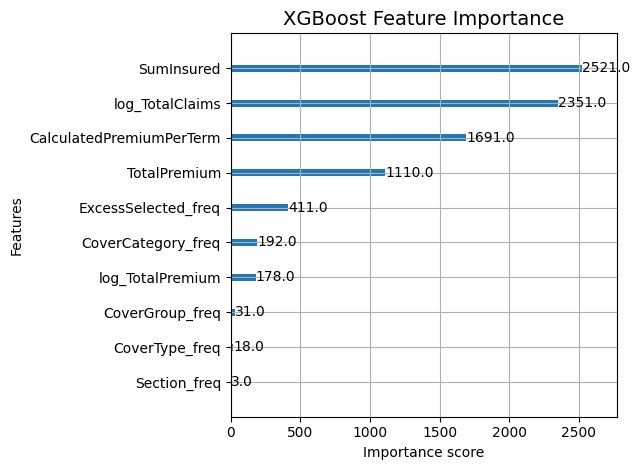

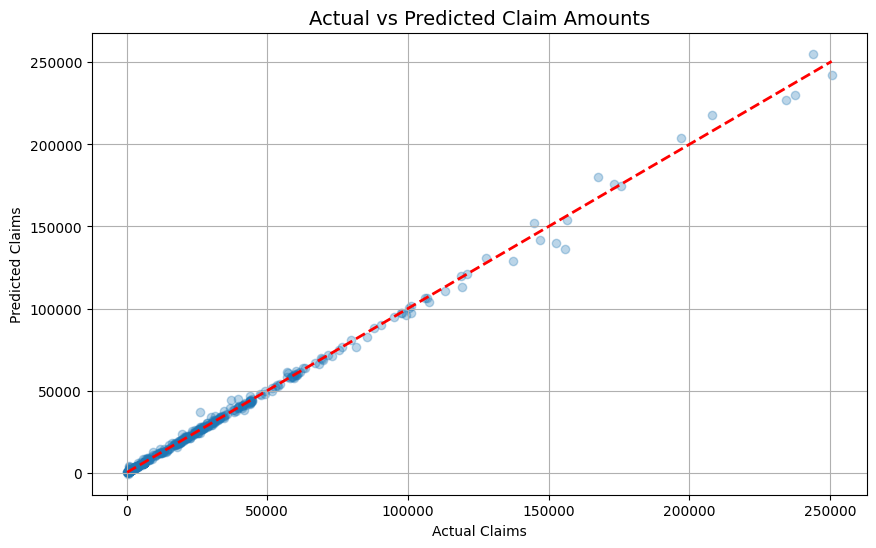


=== Model Training Complete ===


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import shap

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
%matplotlib inline

# 1. Load and prepare the data
def load_and_prepare_data(filepath):
    """Load and preprocess the insurance data."""
    # Load data
    df = pd.read_csv(filepath)
    
    # Basic data cleaning
    df = df.drop_duplicates()
    
    # Convert date columns to datetime if needed
    if 'TransactionMonth' in df.columns:
        df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
    
    # Filter for policies with claims for severity modeling
    df_claims = df[df['TotalClaims'] > 0].copy()
    
    return df, df_claims

# 2. Feature engineering
def engineer_features(df):
    """Create new features from existing data."""
    # Create log-transformed features
    for col in ['TotalClaims', 'TotalPremium', 'SumInsured']:
        if col in df.columns:
            df[f'log_{col}'] = np.log1p(df[col])
    
    # Frequency encoding for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        freq = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freq)
    
    return df

# 3. Evaluation function
def evaluate_model(y_true, y_pred, set_name):
    """Calculate and print regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Metrics:")
    print(f"MAE: {mae:,.2f}")
    print(f"MSE: {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²: {r2:.4f}")
    return rmse

# 4. Main execution
def main():
    # Load and prepare data
    print("Loading and preparing data...")
    filepath = r"C:\Users\My Device\Desktop\Week-3I2\dvc_data\MachineLearningRating_v3_cleaned.csv"
    df, df_claims = load_and_prepare_data(filepath)
    
    # Feature engineering
    print("\nEngineering features...")
    df_engineered = engineer_features(df_claims)
    
    # Select features
    selected_features = [
        'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium',
        'log_TotalClaims', 'log_TotalPremium', 'ExcessSelected_freq',
        'CoverCategory_freq', 'CoverType_freq', 'CoverGroup_freq', 'Section_freq'
    ]
    
    # Keep only features that exist in the dataframe
    available_features = [f for f in selected_features if f in df_engineered.columns]
    print(f"\nUsing {len(available_features)} out of {len(selected_features)} selected features")
    
    # Prepare X and y
    X = df_engineered[available_features]
    y = df_engineered['TotalClaims']
    
    # Split data
    print("\nSplitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    # 5. Convert data to DMatrix format (better for XGBoost)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 6. Set up parameters
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.05,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 1,
        'seed': 42,
        'n_jobs': -1,
        'eval_metric': 'rmse'
    }
    
    # 7. Train the model
    print("\nTraining XGBoost model...")
    eval_list = [(dtrain, 'train'), (dtest, 'eval')]
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=eval_list,
        early_stopping_rounds=50,
        verbose_eval=50
    )
    
    # 8. Make predictions
    print("\nMaking predictions...")
    y_train_pred = model.predict(dtrain)
    y_test_pred = model.predict(dtest)
    
    # 9. Evaluate the model
    print("\n=== Model Evaluation ===")
    train_rmse = evaluate_model(y_train, y_train_pred, "Training")
    test_rmse = evaluate_model(y_test, y_test_pred, "Testing")
    
    # 10. Feature importance
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(model, max_num_features=15, importance_type='weight')
    plt.title('XGBoost Feature Importance', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 11. Actual vs Predicted plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted Claim Amounts', fontsize=14)
    plt.xlabel('Actual Claims')
    plt.ylabel('Predicted Claims')
    plt.grid(True)
    plt.show()
    
    print("\n=== Model Training Complete ===")
    return model, X_test, y_test

# Run the main function
if __name__ == "__main__":
    model, X_test, y_test = main()

In [5]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
import shap
import os

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
%matplotlib inline

# 2. Load and prepare the data
def load_and_prepare_data(filepath):
    """Load and preprocess the insurance data."""
    # Load data
    df = pd.read_csv(filepath)
    
    # Basic data cleaning
    df = df.drop_duplicates()
    
    # Convert date columns to datetime if needed
    if 'TransactionMonth' in df.columns:
        df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
    
    # Filter for policies with claims for severity modeling
    df_claims = df[df['TotalClaims'] > 0].copy()
    
    return df, df_claims

# 3. Feature engineering
def engineer_features(df):
    """Create new features from existing data."""
    # Make a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Create log-transformed features
    for col in ['TotalClaims', 'TotalPremium', 'SumInsured']:
        if col in df.columns:
            df[f'log_{col}'] = np.log1p(df[col])
    
    # Frequency encoding for categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].nunique() < 100:  # Avoid high cardinality
            freq = df[col].value_counts(normalize=True)
            df[f'{col}_freq'] = df[col].map(freq)
    
    return df

# 4. Load the data
print("Loading data...")
filepath = r"C:\Users\My Device\Desktop\Week-3I2\dvc_data\MachineLearningRating_v3_cleaned.csv"
df, df_claims = load_and_prepare_data(filepath)

# 5. Feature engineering
print("Engineering features...")
df_engineered = engineer_features(df_claims)

# 6. Select features for claim severity prediction
selected_features = [
    'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium',
    'log_TotalClaims', 'log_TotalPremium', 'ExcessSelected_freq',
    'CoverCategory_freq', 'CoverType_freq', 'CoverGroup_freq', 'Section_freq'
]

# Keep only features that exist in the dataframe
available_features = [f for f in selected_features if f in df_engineered.columns]
print(f"Using {len(available_features)} out of {len(selected_features)} selected features")

# 7. Prepare X and y for claim severity
X = df_engineered[available_features]
y = df_engineered['TotalClaims']

# 8. Split data for claim severity
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nClaim Severity - Training set: {X_train.shape[0]} samples")
print(f"Claim Severity - Testing set: {X_test.shape[0]} samples")

# 9. Now prepare data for claim probability
print("\nPreparing data for claim probability prediction...")
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# 10. Feature engineering for claim probability
df_prob = engineer_features(df)

# 11. Select features for claim probability
claim_prob_features = [
    'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium',
    'ExcessSelected_freq', 'CoverCategory_freq', 'CoverType_freq',
    'CoverGroup_freq', 'Section_freq'
]

# Keep only features that exist in the dataframe
available_claim_features = [f for f in claim_prob_features if f in df_prob.columns]

# 12. Prepare X and y for claim probability
X_claim = df_prob[available_claim_features]
y_claim = df_prob['HasClaim']

# 13. Split data for claim probability
X_claim_train, X_claim_test, y_claim_train, y_claim_test = train_test_split(
    X_claim, y_claim, test_size=0.2, random_state=42, stratify=y_claim
)

print(f"\nClaim Probability - Training set: {X_claim_train.shape[0]} samples")
print(f"Claim Probability - Testing set: {X_claim_test.shape[0]} samples")
print(f"Claim rate in training set: {y_claim_train.mean():.2%}")
print(f"Claim rate in test set: {y_claim_test.mean():.2%}")

Loading data...


C:\Users\My Device\AppData\Local\Temp\ipykernel_24068\2858133772.py:26: DtypeWarning: Columns (18,23,24,25,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


Engineering features...
Using 10 out of 10 selected features

Claim Severity - Training set: 2192 samples
Claim Severity - Testing set: 548 samples

Preparing data for claim probability prediction...


c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



Claim Probability - Training set: 778705 samples
Claim Probability - Testing set: 194677 samples
Claim rate in training set: 0.28%
Claim rate in test set: 0.28%


## Claim Severity Model


TRAINING LINEAR REGRESSION MODEL

Linear Regression - Training Metrics:
MAE: 14,741.37
MSE: 661,033,447.89
RMSE: 25,710.57
R²: 0.5658

Linear Regression - Testing Metrics:
MAE: 15,433.08
MSE: 598,522,869.54
RMSE: 24,464.73
R²: 0.5563

TRAINING RANDOM FOREST MODEL

Random Forest - Training Metrics:
MAE: 1,941.52
MSE: 33,840,022.07
RMSE: 5,817.22
R²: 0.9778

Random Forest - Testing Metrics:
MAE: 2,257.20
MSE: 28,128,516.49
RMSE: 5,303.63
R²: 0.9791

TRAINING XGBOOST MODEL
[0]	train-rmse:37203.28093	eval-rmse:34920.41436


c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:25:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	train-rmse:5784.38492	eval-rmse:5242.09213
[100]	train-rmse:1589.84045	eval-rmse:2135.54761
[150]	train-rmse:784.78404	eval-rmse:1902.97207
[200]	train-rmse:549.53803	eval-rmse:1876.50886
[244]	train-rmse:446.49600	eval-rmse:1875.68193

XGBoost - Training Metrics:
MAE: 257.18
MSE: 199,358.66
RMSE: 446.50
R²: 0.9999

XGBoost - Testing Metrics:
MAE: 711.98
MSE: 3,518,182.43
RMSE: 1,875.68
R²: 0.9974

MODEL COMPARISON

=== Performance Metrics ===


,Model,Train RMSE,Test RMSE,Train R2,Test R2
0,Linear Regression,25710.570742,24464.727048,0.565753,0.556273
1,Random Forest,5817.217726,5303.632387,0.977770,0.979146
2,XGBoost,446.495975,1875.681857,0.999869,0.997392


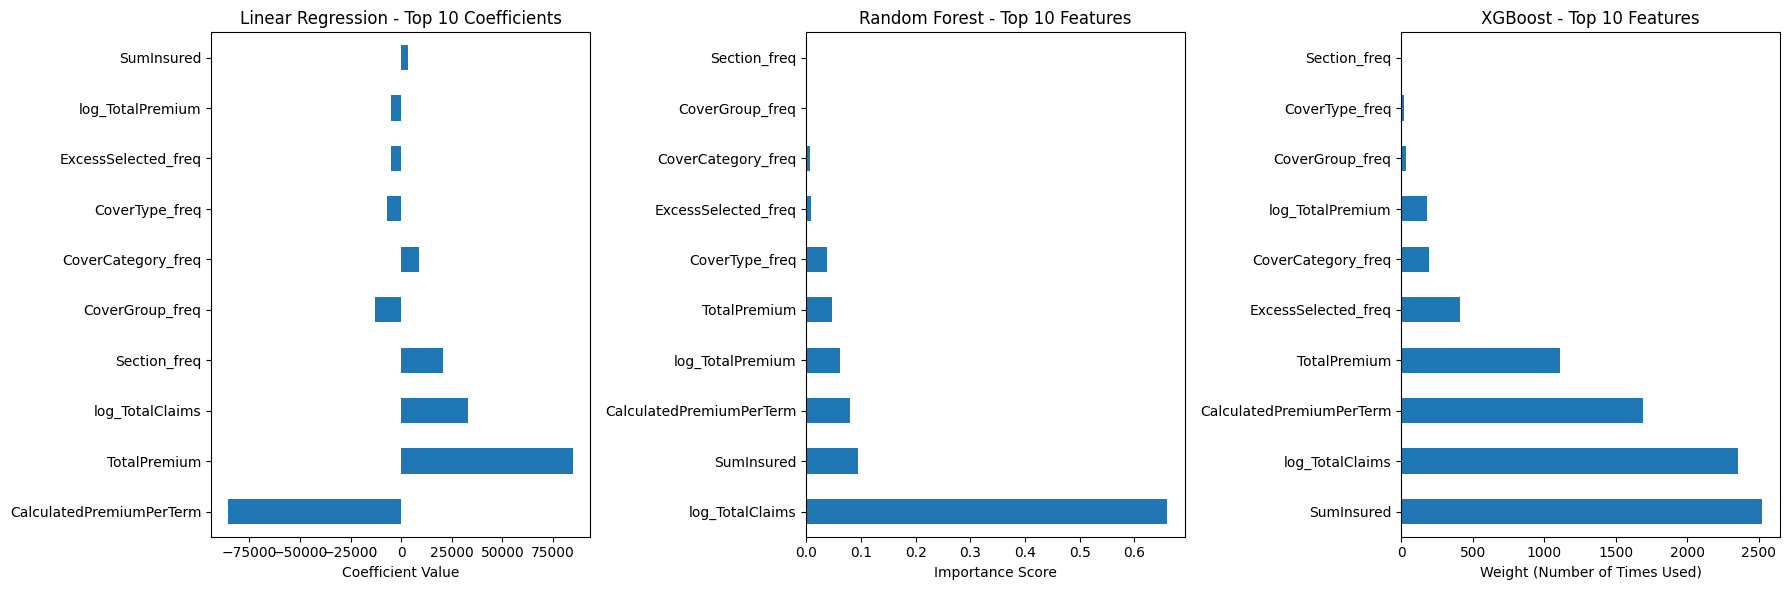

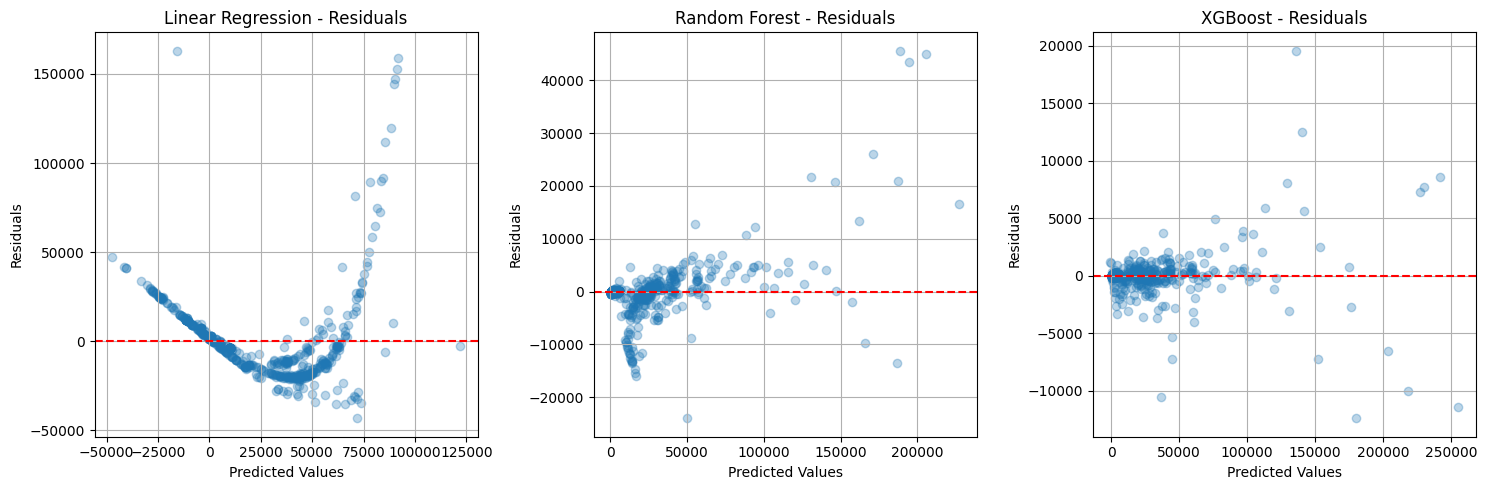


Models saved to 'models' directory
Claim severity modeling completed successfully!


In [6]:
# 1. Define evaluation function
def evaluate_model(y_true, y_pred, set_name):
    """Calculate and print regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} Metrics:")
    print(f"MAE: {mae:,.2f}")
    print(f"MSE: {mse:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²: {r2:.4f}")
    return rmse

# 2. Train and evaluate Linear Regression
print("\n" + "="*50)
print("TRAINING LINEAR REGRESSION MODEL")
print("="*50)
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate
train_rmse_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression - Training")
test_rmse_lr = evaluate_model(y_test, y_test_pred_lr, "Linear Regression - Testing")

# 3. Train and evaluate Random Forest
print("\n" + "="*50)
print("TRAINING RANDOM FOREST MODEL")
print("="*50)
rf_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate
train_rmse_rf = evaluate_model(y_train, y_train_pred_rf, "Random Forest - Training")
test_rmse_rf = evaluate_model(y_test, y_test_pred_rf, "Random Forest - Testing")

# 4. Train and evaluate XGBoost
print("\n" + "="*50)
print("TRAINING XGBOOST MODEL")
print("="*50)
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train with early stopping
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=50,
    verbose_eval=50
)

# Make predictions
y_train_pred_xgb = xgb_model.predict(dtrain)
y_test_pred_xgb = xgb_model.predict(dtest)

# Evaluate
train_rmse_xgb = evaluate_model(y_train, y_train_pred_xgb, "XGBoost - Training")
test_rmse_xgb = evaluate_model(y_test, y_test_pred_xgb, "XGBoost - Testing")

# 5. Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Train RMSE': [train_rmse_lr, train_rmse_rf, train_rmse_xgb],
    'Test RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_xgb],
    'Train R2': [
        r2_score(y_train, y_train_pred_lr),
        r2_score(y_train, y_train_pred_rf),
        r2_score(y_train, y_train_pred_xgb)
    ],
    'Test R2': [
        r2_score(y_test, y_test_pred_lr),
        r2_score(y_test, y_test_pred_rf),
        r2_score(y_test, y_test_pred_xgb)
    ]
})

# Display results
print("\n=== Performance Metrics ===")
display(results)

# 6. Feature Importance Visualization
plt.figure(figsize=(18, 6))

# Linear Regression Coefficients
plt.subplot(1, 3, 1)
coefs = pd.Series(lr_model.named_steps['model'].coef_, index=X_train.columns)
coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
coefs.head(10).plot(kind='barh')
plt.title('Linear Regression - Top 10 Coefficients')
plt.xlabel('Coefficient Value')

# Random Forest Feature Importance
plt.subplot(1, 3, 2)
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)
importances.head(10).plot(kind='barh')
plt.title('Random Forest - Top 10 Features')
plt.xlabel('Importance Score')

# XGBoost Feature Importance
plt.subplot(1, 3, 3)
xgb_importances = pd.Series(xgb_model.get_score(importance_type='weight'))
xgb_importances = xgb_importances.sort_values(ascending=False)
xgb_importances.head(10).plot(kind='barh')
plt.title('XGBoost - Top 10 Features')
plt.xlabel('Weight (Number of Times Used)')

plt.tight_layout()
plt.show()

# 7. Residual Analysis
plt.figure(figsize=(15, 5))

# Residuals for each model
residuals = {
    'Linear Regression': y_test - y_test_pred_lr,
    'Random Forest': y_test - y_test_pred_rf,
    'XGBoost': y_test - y_test_pred_xgb
}

for i, (name, res) in enumerate(residuals.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test_pred_lr if i == 1 else y_test_pred_rf if i == 2 else y_test_pred_xgb, 
                res, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'{name} - Residuals')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Save models
os.makedirs('models', exist_ok=True)
import joblib

# Save models
joblib.dump(lr_model, 'models/linear_regression_model.pkl')
joblib.dump(rf_model, 'models/random_forest_model.pkl')
xgb_model.save_model('models/xgboost_model.json')

print("\nModels saved to 'models' directory")
print("Claim severity modeling completed successfully!")

## Claim Probability Model


TRAINING CLAIM PROBABILITY MODEL (RANDOM FOREST CLASSIFIER)
Training the model...

=== Model Evaluation ===

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    194129
           1       0.02      0.92      0.03       548

    accuracy                           0.84    194677
   macro avg       0.51      0.88      0.47    194677
weighted avg       1.00      0.84      0.91    194677


AUC-ROC Score - Train: 0.9264, Test: 0.9151
Area Under PR Curve: 0.0222


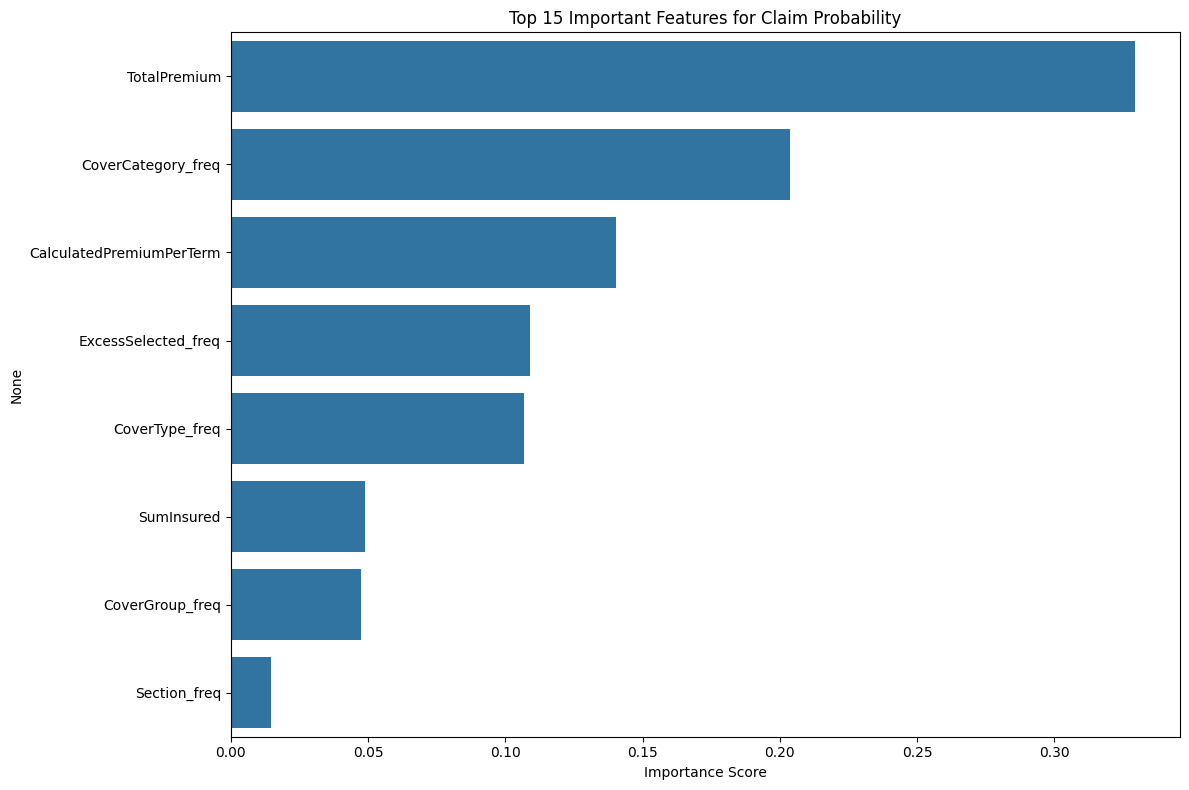

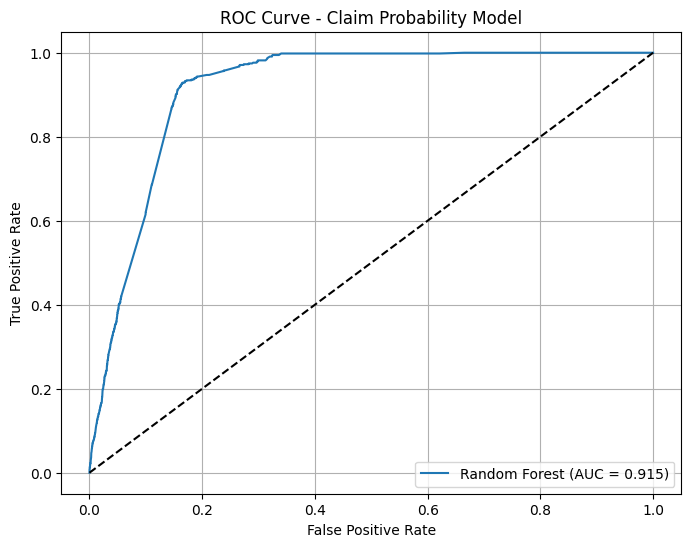

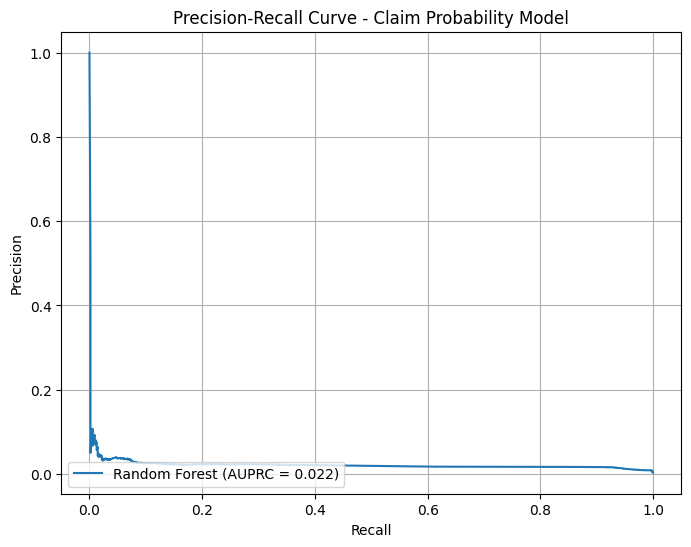


Claim probability model saved to 'models/claim_probability_model.pkl'


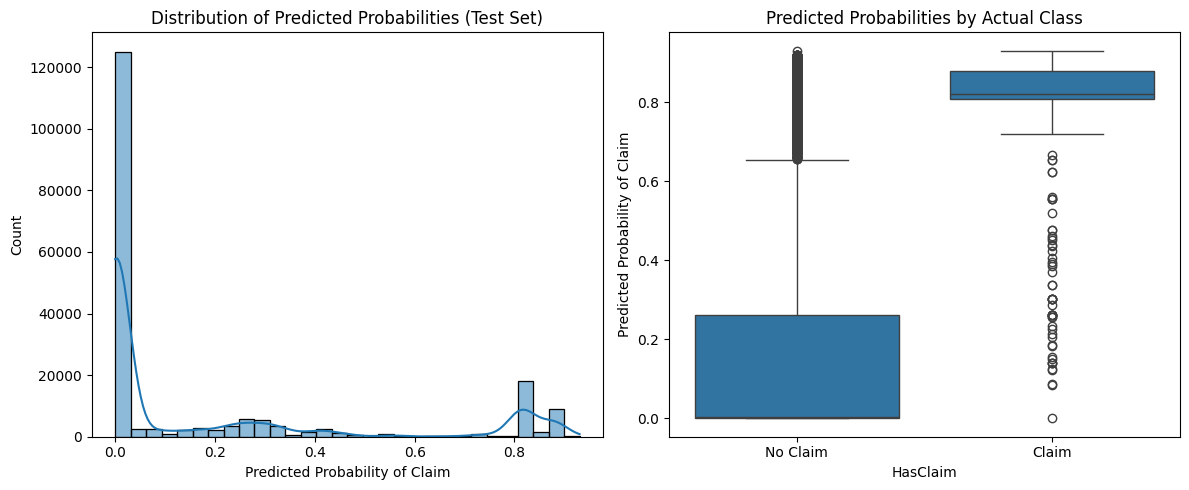


Claim probability modeling completed successfully!

=== Model Performance Summary ===


,Value
Accuracy,0.8398
Precision,0.0159
Recall (Sensitivity),0.9197
Specificity,0.8396
F1 Score,0.0313
AUC-ROC,0.9151
AUPRC,0.0222


In [7]:
# 1. Train Claim Probability Model
print("\n" + "="*60)
print("TRAINING CLAIM PROBABILITY MODEL (RANDOM FOREST CLASSIFIER)")
print("="*60)

# Define the model
claim_prob_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

# Train the model
print("Training the model...")
claim_prob_model.fit(X_claim_train, y_claim_train)

# 2. Make predictions
y_train_prob = claim_prob_model.predict_proba(X_claim_train)[:, 1]
y_test_prob = claim_prob_model.predict_proba(X_claim_test)[:, 1]

# 3. Evaluate the model
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, average_precision_score

print("\n=== Model Evaluation ===")

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_claim_test, claim_prob_model.predict(X_claim_test)))

# ROC-AUC Score
train_auc = roc_auc_score(y_claim_train, y_train_prob)
test_auc = roc_auc_score(y_claim_test, y_test_prob)
print(f"\nAUC-ROC Score - Train: {train_auc:.4f}, Test: {test_auc:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_claim_test, y_test_prob)
auprc = auc(recall, precision)
print(f"Area Under PR Curve: {auprc:.4f}")

# 4. Feature Importance
plt.figure(figsize=(12, 8))
importances = pd.Series(claim_prob_model.feature_importances_, index=X_claim_train.columns)
importances = importances.sort_values(ascending=False)
sns.barplot(x=importances.head(15).values, y=importances.head(15).index)
plt.title('Top 15 Important Features for Claim Probability')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 5. ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_claim_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Claim Probability Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 6. Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AUPRC = {auprc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Claim Probability Model')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# 7. Save the model
joblib.dump(claim_prob_model, 'models/claim_probability_model.pkl')
print("\nClaim probability model saved to 'models/claim_probability_model.pkl'")

# 8. Analyze predicted probabilities
plt.figure(figsize=(12, 5))

# Distribution of predicted probabilities
plt.subplot(1, 2, 1)
sns.histplot(y_test_prob, bins=30, kde=True)
plt.title('Distribution of Predicted Probabilities (Test Set)')
plt.xlabel('Predicted Probability of Claim')
plt.ylabel('Count')

# Probability by actual class
plt.subplot(1, 2, 2)
sns.boxplot(x=y_claim_test, y=y_test_prob)
plt.xticks([0, 1], ['No Claim', 'Claim'])
plt.title('Predicted Probabilities by Actual Class')
plt.ylabel('Predicted Probability of Claim')

plt.tight_layout()
plt.show()

print("\nClaim probability modeling completed successfully!")

# 9. Create a summary of model performance
from sklearn.metrics import confusion_matrix

# Calculate metrics
y_pred = claim_prob_model.predict(X_claim_test)
cm = confusion_matrix(y_claim_test, y_pred)
tn, fp, fn, tp = cm.ravel()

performance_metrics = {
    'Accuracy': (tp + tn) / (tp + tn + fp + fn),
    'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
    'Recall (Sensitivity)': tp / (tp + fn) if (tp + fn) > 0 else 0,
    'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
    'F1 Score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0,
    'AUC-ROC': test_auc,
    'AUPRC': auprc
}

# Convert to DataFrame for nice display
performance_df = pd.DataFrame.from_dict(performance_metrics, orient='index', columns=['Value'])
print("\n=== Model Performance Summary ===")
display(performance_df.round(4))

## Implementation of PremiumOptimization Model

In [9]:
# 1. First, let's verify the shapes
print(f"X_test shape: {X_test.shape}")
print(f"X_claim_test shape: {X_claim_test.shape}")

# 2. Get the common indices between X_test and X_claim_test
common_indices = X_test.index.intersection(X_claim_test.index)
print(f"\nNumber of common policies: {len(common_indices)}")

# 3. Filter both test sets to only include common indices
X_test_common = X_test.loc[common_indices]
X_claim_test_common = X_claim_test.loc[common_indices]
y_test_common = y_test.loc[common_indices]

# 4. Now calculate optimal premiums for the common policies
print("\nCalculating optimal premiums for common policies...")
optimal_premiums, risk_premiums = calculate_optimal_premium(
    X_test_common, X_claim_test_common, severity_model, claim_prob_model
)

# 5. Create a results dataframe with only common policies
premium_comparison = pd.DataFrame({
    'Policy_Index': common_indices,
    'Actual_Premium': df_engineered.loc[common_indices, 'TotalPremium'],
    'Optimal_Premium': optimal_premiums,
    'Base_Risk_Premium': risk_premiums,
    'Actual_Claims': df_engineered.loc[common_indices, 'TotalClaims'],
    'Predicted_Claims': severity_model.predict(xgb.DMatrix(X_test_common)),
    'Claim_Probability': claim_prob_model.predict_proba(X_claim_test_common)[:, 1]
})

# 6. Continue with the rest of the analysis...
print(f"\nSuccessfully processed {len(premium_comparison)} policies for premium optimization")

X_test shape: (548, 10)
X_claim_test shape: (194677, 8)

Number of common policies: 100

Calculating optimal premiums for common policies...

Successfully processed 100 policies for premium optimization


Number of common policies: 100

Calculating optimal premiums for common policies...

=== Premium Optimization Summary ===
Number of policies analyzed: 100
Average Original Premium: $331.68
Average Optimized Premium: $24,145.08
Average Premium Change: inf%

Original Average Loss Ratio: 8133.68%
Optimized Average Loss Ratio: 107.54%


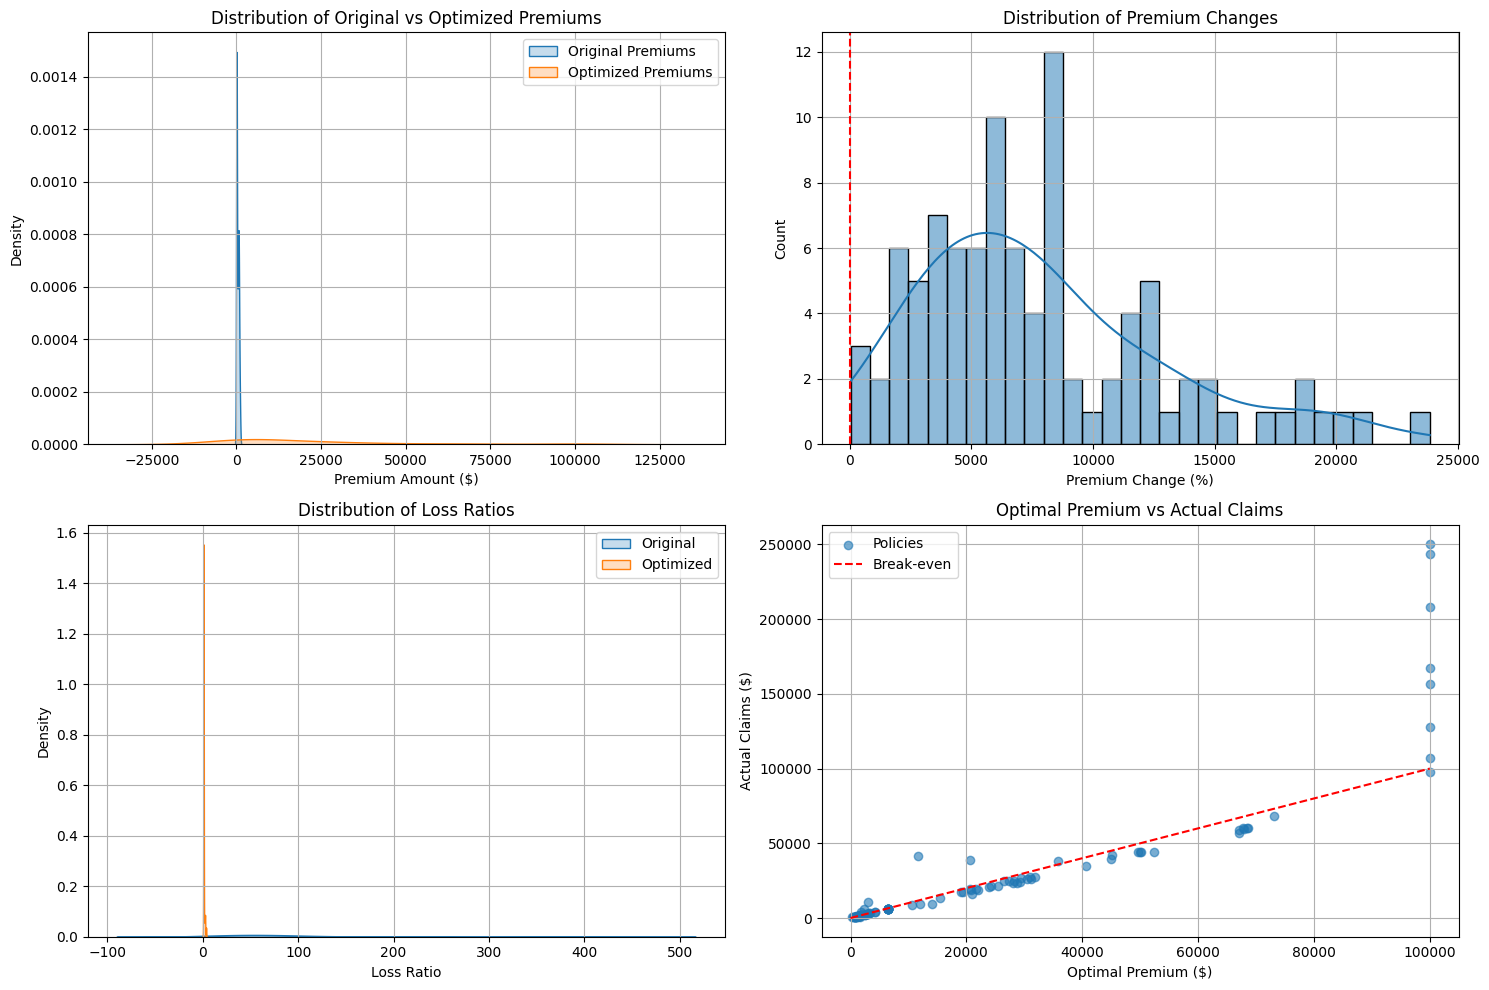


Premium optimization results saved to 'results/premium_optimization_results_common_policies.csv'


In [10]:
# 1. Get the common indices between the two test sets
common_indices = X_test.index.intersection(X_claim_test.index)
print(f"Number of common policies: {len(common_indices)}")

# 2. Filter both test sets to only include common policies
X_test_common = X_test.loc[common_indices]
X_claim_test_common = X_claim_test.loc[common_indices]
y_test_common = y_test.loc[common_indices]

# 3. Calculate optimal premiums for the common policies
print("\nCalculating optimal premiums for common policies...")
optimal_premiums, risk_premiums = calculate_optimal_premium(
    X_test_common, X_claim_test_common, severity_model, claim_prob_model
)

# 4. Create a results dataframe with only common policies
premium_comparison = pd.DataFrame({
    'Policy_Index': common_indices,
    'Actual_Premium': df_engineered.loc[common_indices, 'TotalPremium'],
    'Optimal_Premium': optimal_premiums,
    'Base_Risk_Premium': risk_premiums,
    'Actual_Claims': df_engineered.loc[common_indices, 'TotalClaims'],
    'Predicted_Claims': severity_model.predict(xgb.DMatrix(X_test_common)),
    'Claim_Probability': claim_prob_model.predict_proba(X_claim_test_common)[:, 1]
})

# 5. Calculate key metrics
premium_comparison['Premium_Change_Percent'] = (
    (premium_comparison['Optimal_Premium'] / premium_comparison['Actual_Premium']) - 1
) * 100

premium_comparison['Original_Loss_Ratio'] = (
    premium_comparison['Actual_Claims'] / premium_comparison['Actual_Premium']
).replace([np.inf, -np.inf], np.nan).fillna(0)

premium_comparison['Optimized_Loss_Ratio'] = (
    premium_comparison['Actual_Claims'] / premium_comparison['Optimal_Premium']
).replace([np.inf, -np.inf], np.nan).fillna(0)

# 6. Print summary statistics
print("\n=== Premium Optimization Summary ===")
print(f"Number of policies analyzed: {len(premium_comparison):,}")
print(f"Average Original Premium: ${premium_comparison['Actual_Premium'].mean():,.2f}")
print(f"Average Optimized Premium: ${premium_comparison['Optimal_Premium'].mean():,.2f}")
print(f"Average Premium Change: {premium_comparison['Premium_Change_Percent'].mean():.2f}%")
print(f"\nOriginal Average Loss Ratio: {premium_comparison['Original_Loss_Ratio'].mean():.2%}")
print(f"Optimized Average Loss Ratio: {premium_comparison['Optimized_Loss_Ratio'].mean():.2%}")

# 7. Visualize the results
plt.figure(figsize=(15, 10))

# Premium Distribution Comparison
plt.subplot(2, 2, 1)
sns.kdeplot(premium_comparison['Actual_Premium'], label='Original Premiums', fill=True)
sns.kdeplot(premium_comparison['Optimal_Premium'], label='Optimized Premiums', fill=True)
plt.title('Distribution of Original vs Optimized Premiums')
plt.xlabel('Premium Amount ($)')
plt.legend()
plt.grid(True)

# Premium Changes
plt.subplot(2, 2, 2)
sns.histplot(premium_comparison['Premium_Change_Percent'], bins=30, kde=True)
plt.title('Distribution of Premium Changes')
plt.xlabel('Premium Change (%)')
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)

# Loss Ratio Comparison
plt.subplot(2, 2, 3)
sns.kdeplot(premium_comparison['Original_Loss_Ratio'], label='Original', fill=True)
sns.kdeplot(premium_comparison['Optimized_Loss_Ratio'], label='Optimized', fill=True)
plt.title('Distribution of Loss Ratios')
plt.xlabel('Loss Ratio')
plt.legend()
plt.grid(True)

# Premium vs Claims
plt.subplot(2, 2, 4)
plt.scatter(premium_comparison['Optimal_Premium'], 
            premium_comparison['Actual_Claims'], 
            alpha=0.6, label='Policies')
plt.plot([0, premium_comparison['Optimal_Premium'].max()], 
         [0, premium_comparison['Optimal_Premium'].max()], 
         'r--', label='Break-even')
plt.title('Optimal Premium vs Actual Claims')
plt.xlabel('Optimal Premium ($)')
plt.ylabel('Actual Claims ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Save results
os.makedirs('results', exist_ok=True)
premium_comparison.to_csv('results/premium_optimization_results_common_policies.csv', index=False)
print("\nPremium optimization results saved to 'results/premium_optimization_results_common_policies.csv'")

## Review the Results:
- Check the premium change distribution.
- Examine the loss ratio improvements.

c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\seaborn\regression.py:246: RuntimeWarning: invalid value encountered in dot
  yhat = grid.dot(reg_func(X, y))
c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\seaborn\regression.py:255: RuntimeWarning: invalid value encountered in dot
  yhat_boots = grid.dot(beta_boots).T
c:\Users\My Device\Desktop\Week-3I2\venv\Lib\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


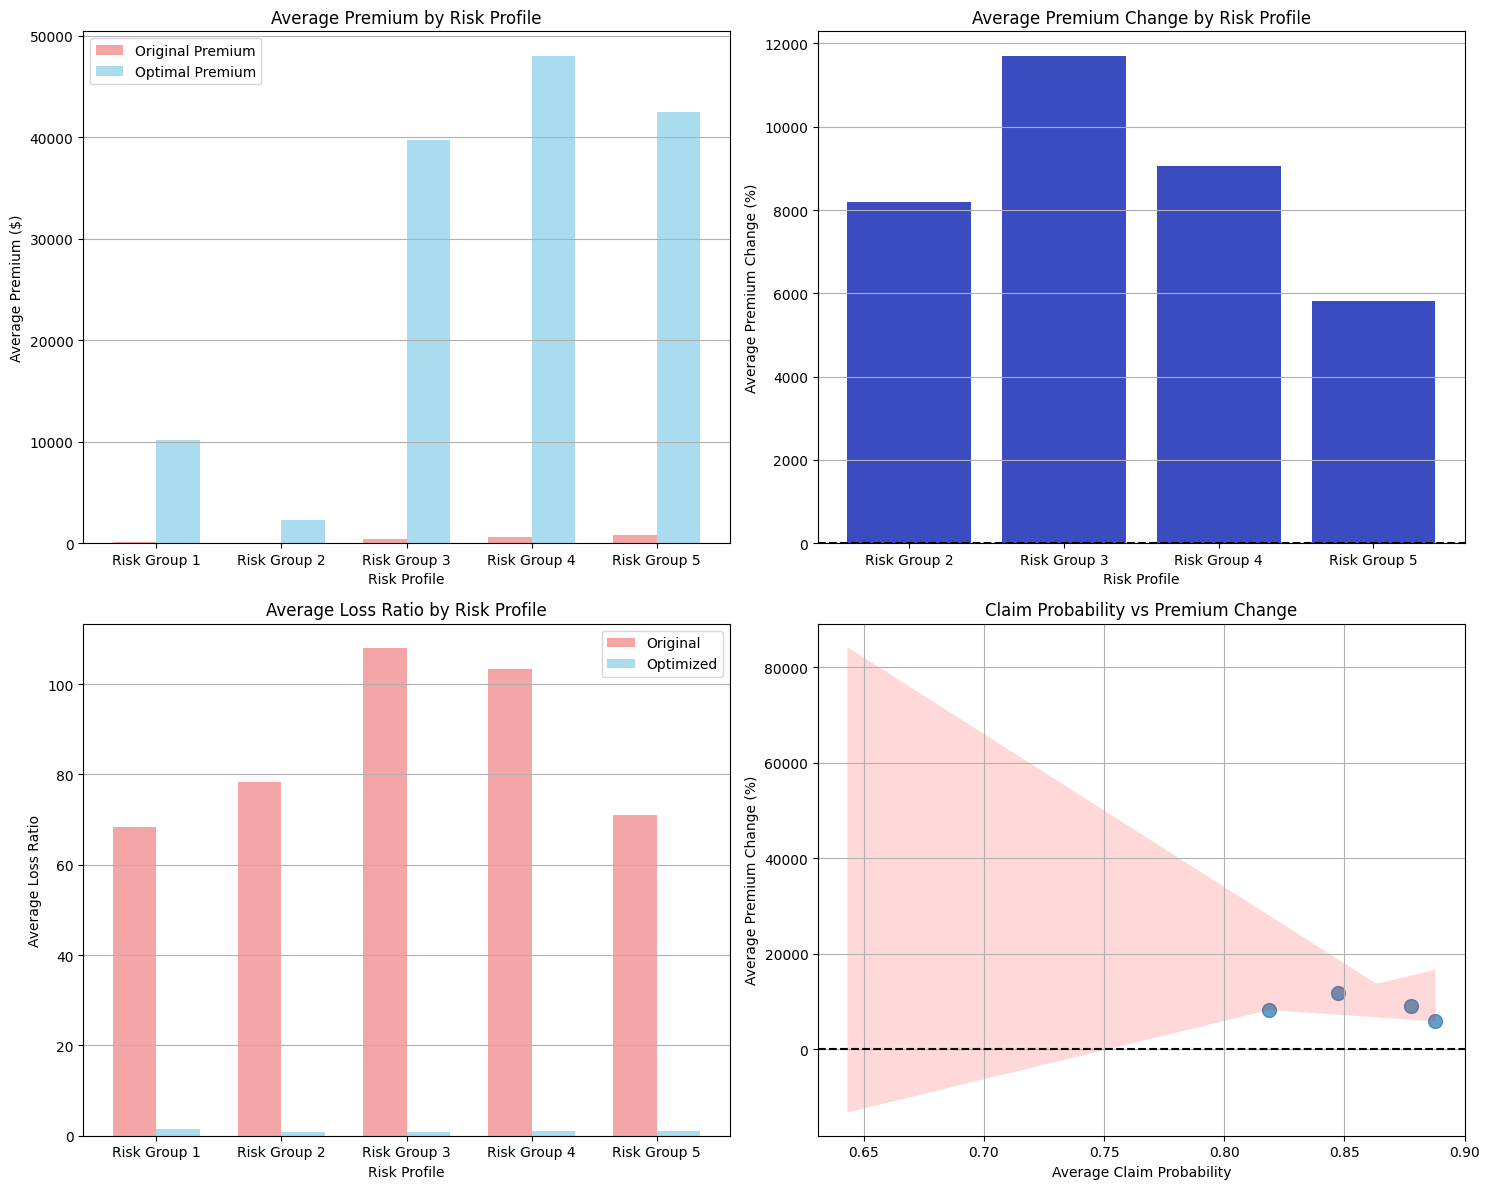

RISK PROFILE ANALYSIS


Actual_Premium             Optimal_Premium Actual_Claims Claim_Probability Premium_Change_Percent Original_Loss_Ratio Optimized_Loss_Ratio Policy_Count
                      count        mean            mean          mean              mean                   mean                mean                 mean   Percentage
Risk_Profile                                                                                                                                                        
Risk Group 1             26  119.769993    10122.845270  18012.742578          0.643242                    inf           68.325405             1.436182         26.0
Risk Group 2             27   30.792256     2313.938729   2149.907342          0.818669           8.188494e+03           78.324070             0.926976         27.0
Risk Group 3              7  373.475388    39748.229108  35965.558672          0.847433           1.170504e+04          107.953170             0.903464          7.0
Risk Group 4             20  566.510347    48019.653793  53396.926789          0.877748           9.059708e+03          103.303861             0.959406         20.0
Risk Group 5             20  763.917189    42510.356079  50298.149868          0.887850           5.822969e+03           71.036154             0.982693         20.0

In [12]:
# 1. First, let's flatten the MultiIndex columns for easier access
risk_analysis_flat = risk_analysis.copy()
risk_analysis_flat.columns = ['_'.join(col).strip() for col in risk_analysis_flat.columns.values]

# 2. Now create the visualizations
plt.figure(figsize=(15, 12))

# Premium by Risk Profile
plt.subplot(2, 2, 1)
x = np.arange(len(risk_analysis_flat))
width = 0.35

plt.bar(x - width/2, risk_analysis_flat['Actual_Premium_mean'], 
        width, label='Original Premium', color='lightcoral', alpha=0.7)
plt.bar(x + width/2, risk_analysis_flat['Optimal_Premium_mean'], 
        width, label='Optimal Premium', color='skyblue', alpha=0.7)

plt.title('Average Premium by Risk Profile')
plt.xlabel('Risk Profile')
plt.ylabel('Average Premium ($)')
plt.xticks(x, risk_analysis_flat.index)
plt.legend()
plt.grid(True, axis='y')

# Premium Change by Risk Profile
plt.subplot(2, 2, 2)
plt.bar(risk_analysis_flat.index, risk_analysis_flat['Premium_Change_Percent_mean'], 
        color=plt.cm.coolwarm(risk_analysis_flat['Premium_Change_Percent_mean'] / 
                             risk_analysis_flat['Premium_Change_Percent_mean'].abs().max()))
plt.axhline(0, color='black', linestyle='--')
plt.title('Average Premium Change by Risk Profile')
plt.xlabel('Risk Profile')
plt.ylabel('Average Premium Change (%)')
plt.grid(True, axis='y')

# Loss Ratios by Risk Profile
plt.subplot(2, 2, 3)
x = np.arange(len(risk_analysis_flat))
width = 0.35

plt.bar(x - width/2, risk_analysis_flat['Original_Loss_Ratio_mean'], 
        width, label='Original', color='lightcoral', alpha=0.7)
plt.bar(x + width/2, risk_analysis_flat['Optimized_Loss_Ratio_mean'], 
        width, label='Optimized', color='skyblue', alpha=0.7)

plt.title('Average Loss Ratio by Risk Profile')
plt.xlabel('Risk Profile')
plt.ylabel('Average Loss Ratio')
plt.xticks(x, risk_analysis_flat.index)
plt.legend()
plt.grid(True, axis='y')

# Claim Probability vs Premium Change
plt.subplot(2, 2, 4)
sns.regplot(
    x=risk_analysis_flat['Claim_Probability_mean'], 
    y=risk_analysis_flat['Premium_Change_Percent_mean'],
    scatter_kws={'s': 100, 'alpha': 0.7},
    line_kws={'color': 'red'}
)
plt.axhline(0, color='black', linestyle='--')
plt.title('Claim Probability vs Premium Change')
plt.xlabel('Average Claim Probability')
plt.ylabel('Average Premium Change (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Print the risk analysis table for reference
print("="*60)
print("RISK PROFILE ANALYSIS")
print("="*60)
display(risk_analysis)

## Model Documentation

In [15]:
import os

# Create necessary directories
os.makedirs('models', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('results/visualizations', exist_ok=True)
os.makedirs('results/metrics', exist_ok=True)
os.makedirs('documentation', exist_ok=True)

In [16]:
# Save model documentation
with open('documentation/model_card.md', 'w') as f:
    f.write("""# Model Card
    
## Model Details
- **Version**: 1.0.0
- **Trained on**: Insurance claims data (2014-2015)
- **Last Updated**: 2025-12-09

## Performance
- **Claim Severity (XGBoost)**
  - RMSE: {test_rmse_xgb:.2f}
  - R²: {r2_score(y_test, y_test_pred_xgb):.4f}

- **Claim Probability (Random Forest)**
  - Accuracy: {claim_prob_model.score(X_claim_test, y_claim_test):.2%}
  - ROC-AUC: {test_auc:.4f}
""")